In [1]:
import h5py
import numpy as np
import pandas as pd


in_file="/data/project/Alzheimer/EM_cluster/pilot/04.EM_input/pyclone_vi/pyclone_vi_220610.h5"


def fix_cluster_ids(df):
    """ Renumber clusters so they are sequential from 0.
    """
    cluster_map = dict(zip(
        df['cluster_id'].unique(), np.arange(df['cluster_id'].nunique())
    ))

    df['cluster_id'] = df['cluster_id'].map(cluster_map)

    return df


def load_results_df(file_name):
    cluster_df = load_cluster_df(file_name)

    loci_df = load_loci_df(file_name)

    df = pd.merge(cluster_df, loci_df, on=['cluster_id'])

    df = df[[
        'mutation_id',
        'sample_id',
        'cluster_id',
        'cellular_prevalence',
        'cellular_prevalence_std',
        'cluster_assignment_prob'
    ]]

    df = df.sort_values(by=['cluster_id', 'mutation_id', 'sample_id'])

    return df


def load_cluster_df(file_name):
    with h5py.File(file_name, 'r') as fh:
        samples = fh['/data/samples'].asstr()[()]

        theta = fh['/var_params/theta'][()]

        z = fh['/var_params/z'][()]

    labels = np.argmax(z, axis=1)

    clusters = np.unique(labels)

    df = []

    x = np.linspace(0, 1, theta.shape[2])

    for i, sample_id in enumerate(samples):
        for cluster_id in clusters:
            q = theta[cluster_id, i]

            mean = np.sum(x * q)

            var = np.sum(x ** 2 * q) - mean ** 2

            std = np.sqrt(var)

            df.append({
                'sample_id': sample_id,
                'cluster_id': cluster_id,
                'cellular_prevalence': mean,
                'cellular_prevalence_std': std
            })

    df = pd.DataFrame(df)

    df = df[['sample_id', 'cluster_id', 'cellular_prevalence', 'cellular_prevalence_std']]

    return df


def load_loci_df(file_name):
    with h5py.File(file_name, 'r') as fh:
        mutations = fh['/data/mutations'].asstr()[()]

        z = fh['/var_params/z'][()]

    labels = np.argmax(z, axis=1)

    probs = np.max(z, axis=1)

    df = pd.DataFrame({
        'mutation_id': mutations,
        'cluster_id': labels,
        'cluster_assignment_prob': probs
    })

    df = df[['mutation_id', 'cluster_id', 'cluster_assignment_prob']]

    return df


df = load_results_df(in_file)
df = fix_cluster_ids(df)
df = df.sort_values(by = "mutation_id")

/home/goldpm1/miniconda3/envs/cnvpytor/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in sqrt


In [83]:
b1 = df[df["sample_id"] == "block0"].iloc[:, 0:4]
b2 = df[df["sample_id"] == "block1"].iloc[:, 0:4]
b = pd.merge (b1, b2, left_on = "mutation_id", right_on = "mutation_id")

In [84]:
np_vaf = pd.read_csv("/data/project/Alzheimer/EM_cluster/pilot/04.EM_input/sampling_1000.txt", sep = "\t")
np_vaf.rename(columns = {"Unnamed: 0":"mutation_id"}, inplace = True) 
np_vaf.head()

,mutation_id,block0,block1,block2
0,chr1_1050446,0.01,0.01,0.04
1,chr1_1332968,0.02,0.01,0.05
2,chr1_1399095,0.07,0.26,0.03
3,chr1_2321531,0.15,0.09,0.15
4,chr1_7664353,0.02,0.02,0.04


In [85]:
b = pd.merge (b, np_vaf, left_on = "mutation_id", right_on = "mutation_id")

<AxesSubplot:xlabel='Feature 1 : VAF*2 of Block 1', ylabel='Feature 2 : VAF*2 of Block 2'>

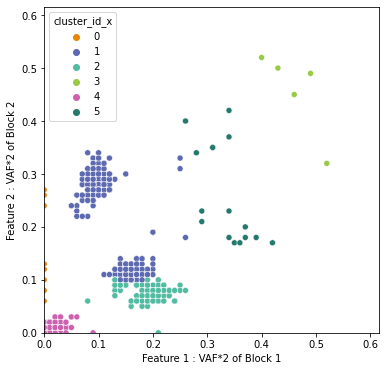

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import palettable
vivid_10 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
colorlist = {key:value for key, value in enumerate(vivid_10)}

plt.figure (figsize = (6,6))
# plt.suptitle ("PyClone_vi : (n = {0}".format(np_vaf.shape[0]))
plt.axis ([0,  np.max(np.array(np_vaf.iloc[:,1:])) * 1.1,  0,  np.max(np.array(np_vaf.iloc[:,1:])) * 1.1])
plt.xlabel ("Feature 1 : VAF*2 of Block 1")
plt.ylabel ("Feature 2 : VAF*2 of Block 2")

palette = sns.color_palette("Paired")
sns.scatterplot(data = b, x = 'block0', y = 'block1', hue = "cluster_id_x", palette = colorlist)

In [72]:
np.array(np_vaf.iloc[:,1:])

array([[0.01, 0.01, 0.03],
       [0.14, 0.06, 0.16],
       [0.02, 0.02, 0.05],
       ...,
       [0.  , 0.  , 0.01],
       [0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ]])